In [ ]:
# %load genetic_algorithm_conversion_facebook.py
#!/usr/bin/env python

# In[4]:

import math
import numpy as np
# from GAIndividual import GAIndividual
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import index_collector_conversion_facebook as collector
sizepop, vardim, MAXGEN, params = 500, 8, 15, [0.9, 0.1, 0.5]
DATABASE = "dev_facebook_test"
DATE = datetime.datetime.today().date() -datetime.timedelta(1)
OBJECTIVE_LIST = [ 'CONVERSIONS', 'ADD_TO_CART', ]
COST_PER_ACTION = {
    'CONVERSIONS':'cost_per_purchase',
    'ADD_TO_CART':'cost_per_add_to_cart',
    'LANDING_PAGE_VIEW':'cost_per_landing_page_view',
}

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
#         self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#         self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        self.trace[self.t, 0] = self.best.fitness
        self.trace[self.t, 1] = self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print("m1--m2--m3--m4--m5--m6--mspend--mbid")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] +                         (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc().fitness_function( self.chrom, df )

class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def __init__(self, campaign_id=None):
        self.mydb = collector.connectDB( DATABASE )
        self.charge_type = 'CONVERSIONS'
        
    def fitness_function(self, optimal_weight, df):
        self.mydb.close()
        df = df.fillna(0)
        m1 = (df['purchase'] / df['add_to_cart']).iloc[0]
        m2 = 0
        m3 = (df['add_to_cart'] / df['view_content']).iloc[0]
        m4 = (df['view_content'] / df['landing_page_view']).iloc[0]
        m5 = (df['landing_page_view'] / df['link_click']).iloc[0]
        m6 = (df['link_click'] / df['impressions']).iloc[0]
        m_spend = (( df['daily_budget'] - df['spend'] ) / df['daily_budget']).iloc[0]
        m_bid   = (( df['campaign_bid'] - df[ COST_PER_ACTION[self.charge_type] ] ) / df['campaign_bid']).iloc[0]
        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df, charge_type):
        df = df.fillna(0)

        m1 = (df['purchase'] / df['add_to_cart']).iloc[0]
        m2 = 0
        m3 = (df['add_to_cart'] / df['view_content']).iloc[0]
        m4 = (df['view_content'] / df['landing_page_view']).iloc[0]
        m5 = (df['landing_page_view'] / df['link_click']).iloc[0]
        m6 = (df['link_click'] / df['impressions']).iloc[0]
        m_spend = (( df['daily_budget'] - df['spend'] ) / df['daily_budget']).iloc[0]
        m_bid   = (( df['bid_amount'] - df[ COST_PER_ACTION[charge_type] ] ) / df['bid_amount']).iloc[0]
        
        status  = np.array( [m1, m2, m3, m4, m5, m6, m_spend, m_bid] )
        status = np.nan_to_num(status)
        r = np.dot( optimal_weight, status )
        r = np.nan_to_num(r)
        return r
    
    def campaign_status( self, campaign_id ):
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}" .format(campaign_id), con=self.mydb)
        self.mydb.close()
        print(df_camp)
        self.charge_type = df_camp['charge_type'].iloc[0]
        df_camp['campaign_bid'] = df_camp['ai_spend_cap']/df_camp['destination']
        
        campaign_collector = collector.Campaigns(campaign_id)
        insights = campaign_collector.get_campaign_insights(date_preset=collector.DatePreset.lifetime)

        df_insights = pd.DataFrame(insights, index=[0])
        df = pd.concat( [df_insights, df_camp[['campaign_id', 'cost_per_target', 'target', 'campaign_bid', 'daily_budget', 'charge_type']]], axis=1 )
        df.fillna(value=0, inplace=True)
        df = df.convert_objects(convert_numeric=True)

        return df
    
    def adset_status( self, adset_id ):
        df_adset = pd.read_sql("SELECT * FROM adset_conversion_metrics WHERE adset_id={} and DATE(request_time) = '{}' ORDER BY request_time DESC LIMIT 1".format(adset_id, DATE), con=self.mydb)
        self.mydb.close()
        
        adset_collector = collector.AdSets(adset_id)
        insights = adset_collector.retrieve_all(date_preset=collector.DatePreset.lifetime)
        df_insights = pd.DataFrame(insights, index=[0])
        df_insights.fillna(value=0, inplace=True)
        df_insights = df_insights.convert_objects(convert_numeric=True)
        return df_insights

def ga_optimal_weight(campaign_id, df_weight):
    request_time = datetime.datetime.now().date()
    mydb = collector.connectDB( DATABASE )
#     df_weight = pd.read_sql("SELECT * FROM conversion_optimal_weight WHERE campaign_id={}".format(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id={}".format(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = collector.Campaigns(campaign_id).get_adsets_active()
    for adset_id in adset_list:
        df = ObjectiveFunc().adset_status( adset_id )
        df['daily_budget'] = df_camp['daily_budget']
        df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
        df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        if 'bid_amount' in df.columns:
            r = ObjectiveFunc.adset_fitness( df_weight, df, charge_type )
            print(adset_id, r)
            df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r[0], 'request_time':request_time}, index=[0])

            collector.insertion("adset_score", df_final)

In [2]:
def main(campaign_id=None):
    starttime = datetime.datetime.now()
    global df
    if not campaign_id:
        campaign_list = collector.get_running_conversion_campaign()['campaign_id'].unique()
        print('[on-going cnvrsn campaign_list]: ', campaign_list)
        for campaign_id in campaign_list:
            df = ObjectiveFunc().campaign_status(campaign_id)
            df = df.fillna(0)
            df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
            df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
            df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
            print('campaign_id:', campaign_id )
            print('current time: ', starttime )
            bound = np.tile([[0], [10]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc().fitness_function(optimal, df)
            score = np.nan_to_num(score)
            if math.isinf(score):
                print('[main] score is inf, stop assessment')
                return
            weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
            df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

            df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, index=[0])
            df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
            collector.check_optimal_weight(campaign_id, df_final)
            ga_optimal_weight(campaign_id, df_weight)
            print('optimal_weight:', optimal)
            print(datetime.datetime.now()-starttime)
        print(datetime.datetime.now()-starttime)
    else:
        print('campaign_id:', campaign_id )
        print('current time: ', starttime )
        df = ObjectiveFunc().campaign_status(campaign_id)
        df['add_to_cart'].iloc[0] = df['purchase'].iloc[0] if df['add_to_cart'].iloc[0] < df['purchase'].iloc[0] else df['add_to_cart'].iloc[0]
        df['view_content'].iloc[0] = df['add_to_cart'].iloc[0] if df['view_content'].iloc[0] < df['add_to_cart'].iloc[0] else df['view_content'].iloc[0]
        df['landing_page_view'].iloc[0] = df['view_content'].iloc[0] if df['landing_page_view'].iloc[0] < df['view_content'].iloc[0] else df['landing_page_view'].iloc[0]
        bound = np.tile([[0], [10]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc().fitness_function(optimal, df)
        if math.isinf(score):
            print('[main] score is inf, stop assessment')
            return
        weight_columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w_spend', 'w_bid']
        df_weight = pd.DataFrame(data=[optimal], columns=weight_columns, index=[0])

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
        df_final = pd.concat( [df_weight, df_final], axis=1, sort=True, ignore_index=False)
        collector.check_optimal_weight(campaign_id, df_final)
        ga_optimal_weight(campaign_id, df_weight)
        print('optimal_weight:', optimal)
        print('[time taken]: ', datetime.datetime.now()-starttime)    
    print(datetime.datetime.now()-starttime)
    return

[on-going cnvrsn campaign_list]:  [23843467729120098 23843484377040702 23843481678350339 23843473390820344
 23843592731740022 23843592741150022 23843457813880014 23843638403020266]
         campaign_id  destination destination_max  charge_type  \
0  23843467729120098          125            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None         True     2019-08-03          658.167   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0        1550.0          4.25  ...     2019-08-02   2019-08-31     active   

   spend_cap          start_time           stop_time target target_left  \
0      10000 2019-05-02 14:56:07 2019-06-12 12:20:03      6         119   

   target_type  reach  
0  CONVERSIONS  22736  

[1 rows x 25 columns]


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:271: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/tim_su/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


campaign_id: 23843467729120098
current time:  2019-08-04 15:04:54.917624
Generation 0: optimal function value is: 14.716932; average function value is -1.133800
Generation 1: optimal function value is: 14.716932; average function value is -9.512402
Generation 2: optimal function value is: 14.716932; average function value is -10.682777
Generation 3: optimal function value is: 14.716932; average function value is -11.297264
Generation 4: optimal function value is: 14.716932; average function value is -11.618115
Generation 5: optimal function value is: 14.716932; average function value is -12.135365
Generation 6: optimal function value is: 14.716932; average function value is -12.670766
Generation 7: optimal function value is: 14.716932; average function value is -12.750829
Generation 8: optimal function value is: 14.716932; average function value is -12.971716
Generation 9: optimal function value is: 14.716932; average function value is -13.103913
Generation 10: optimal function value i

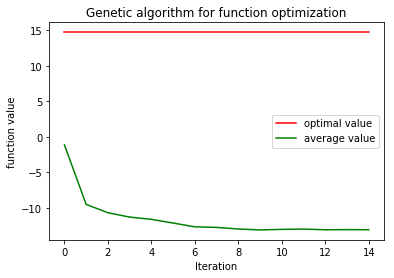

[get_adsets_active] adset_active_list: ['23843677487840098', '23843669340520098', '23843667642790098', '23843663604660098']


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


23843677487840098 [15.20975029]
23843669340520098 [18.70263951]
23843667642790098 [25.68344702]
23843663604660098 [18.04562012]
optimal_weight: [7.92074158 4.19324135 8.924887   7.19474915 9.70276355 6.39510685
 1.41791184 1.02625524]
0:00:43.747537
         campaign_id  destination destination_max  charge_type  \
0  23843484377040702          186            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None        False     2019-08-03          200.812   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0        1500.0           5.5  ...     2019-08-01   2019-08-31     active   

   spend_cap          start_time           stop_time target target_left  \
0      10000 2019-05-27 00:00:44 2019-06-12 12:21:27     32         154   

   target_type  reach  
0  CONVERSIONS  16653  

[1 rows x 25 columns]
campaign_id: 23843484377040702
current time:  2019-08-04 15:04:54.917624
Generation 0: optimal fu

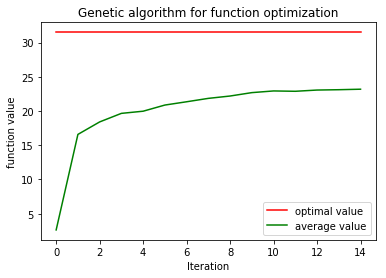

[get_adsets_active] adset_active_list: ['23843655600250702', '23843603174320702', '23843603170470702', '23843484398840702']
23843655600250702 [8.8785693]
23843603174320702 [34.82370129]
23843603170470702 [34.18987524]
23843484398840702 [40.648496]
optimal_weight: [2.67411792 2.27433005 7.88117314 7.71416339 9.89946439 5.27172525
 0.27077087 8.60779844]
0:01:27.119120
         campaign_id  destination destination_max  charge_type  \
0  23843481678350339           85            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None        False     2019-08-02            533.6   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0        1500.0       2.67857  ...     2019-08-01   2019-08-31     active   

   spend_cap          start_time stop_time target target_left  target_type  \
0       None 2019-07-09 18:11:22      None     10          75  CONVERSIONS   

   reach  
0  79290  

[1 rows x 25 column

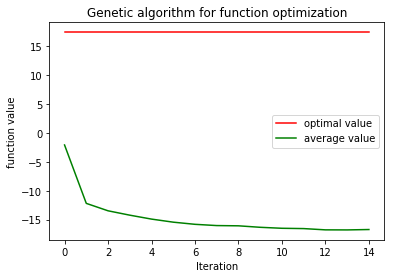

[get_adsets_active] adset_active_list: ['23843538076050339', '23843526758760339', '23843520985210339', '23843490366360339']
23843538076050339 [22.78025305]
23843526758760339 [25.78919089]
23843520985210339 [18.33633793]
23843490366360339 [18.65950517]
optimal_weight: [7.80323414 1.43915892 1.01609881 8.36486286 8.9306084  3.40908418
 0.05052342 8.41096451]
0:02:09.845742
         campaign_id  destination destination_max  charge_type  \
0  23843473390820344          140            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None         True     2019-08-02          28.6471   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0         400.0       2.12069  ...     2019-07-23   2019-09-30     active   

   spend_cap          start_time stop_time target target_left  target_type  \
0       None 2019-07-23 18:36:37      None     17         123  CONVERSIONS   

  reach  
0  5071  

[1 rows x 25 colu

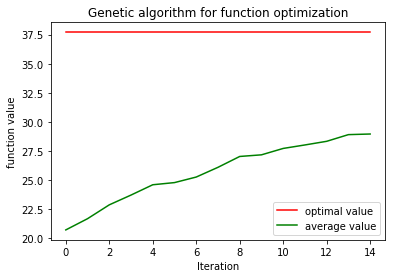

[get_adsets_active] adset_active_list: ['23843499464190344', '23843477946060344', '23843477945310344', '23843476995720344', '23843473402760344', '23843473390840344']
[conversion_index_collector_facebook.AdSets.get_adset_insights] 'NoneType' object is not iterable
23843499464190344 [11.97978411]
23843477946060344 [12.00620118]
23843477945310344 [48.55898086]
23843476995720344 [37.15676381]
23843473402760344 [20.80933049]
23843473390840344 [11.96449115]
optimal_weight: [9.82012975 8.24723352 9.69139814 6.77987899 9.01705056 4.14464499
 2.92380391 9.06328971]
0:02:57.775661
         campaign_id  destination destination_max  charge_type  \
0  23843592731740022           38            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None         True     2019-08-02            419.2   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0        1500.0       2.33333  ...     2019-08-01   2019-08-15     ac

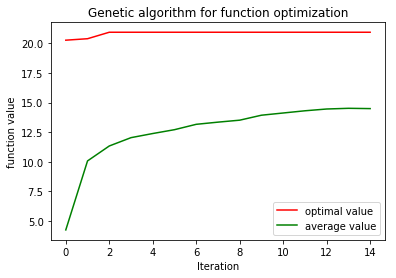

[get_adsets_active] adset_active_list: ['23843595482840022', '23843592731800022', '23843592731780022', '23843592731760022']
23843595482840022 [11.69238964]
23843592731800022 [24.16577402]
23843592731780022 [27.80758319]
23843592731760022 [25.83325772]
optimal_weight: [8.95933815 0.84254595 8.70752265 6.84442762 9.38311459 8.20068135
 0.98023038 7.38997173]
0:03:40.633143
         campaign_id  destination destination_max  charge_type  \
0  23843592741150022           35            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None         True     2019-08-02          490.778   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0        1500.0       2.36364  ...     2019-08-01   2019-08-14     active   

   spend_cap          start_time           stop_time target target_left  \
0       None 2019-08-01 12:49:50 2019-08-14 23:45:00      9          26   

   target_type  reach  
0  CONVERSIONS  2813

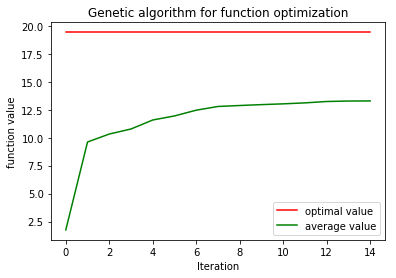

[get_adsets_active] adset_active_list: ['23843592742800022', '23843592742790022', '23843592742770022']
23843592742800022 [20.27947463]
23843592742790022 [22.88054381]
23843592742770022 [16.33667561]
optimal_weight: [4.29344388 1.39542309 6.3631582  9.99711318 9.49138781 3.42905999
 0.22805761 1.56826058]
0:04:20.934845
         campaign_id  destination destination_max  charge_type  \
0  23843457813880014           30            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0      803792276476606         True     2019-08-02              0.0   

   daily_budget  daily_charge  ...  ai_start_date ai_stop_date  ai_status  \
0         800.0       1.07143  ...     2019-08-02   2019-08-31     active   

   spend_cap          start_time stop_time target target_left  target_type  \
0       None 2019-07-09 20:37:29      None      0          30  CONVERSIONS   

  reach  
0   299  

[1 rows x 25 columns]
campaign_id: 23843457813880014
current time:  20

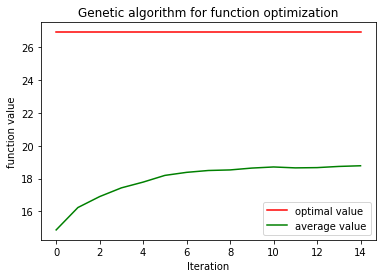

[get_adsets_active] adset_active_list: ['23843519455700014', '23843500088070014', '23843457814070014']
[conversion_index_collector_facebook.AdSets.get_adset_insights] 'NoneType' object is not iterable
23843519455700014 [18.06269799]
[conversion_index_collector_facebook.AdSets.get_adset_insights] 'NoneType' object is not iterable
23843500088070014 [18.25802992]
23843457814070014 [27.26585389]
optimal_weight: [1.42408873 1.75677434 3.45970297 3.75648023 9.06156409 6.76457963
 9.76659617 8.55247497]
0:05:01.323802
         campaign_id  destination destination_max  charge_type  \
0  23843638403020266           13            None  CONVERSIONS   

  custom_conversion_id is_optimized optimized_date  cost_per_target  \
0                 None         None           None              0.0   

   daily_budget  daily_charge  ... ai_start_date ai_stop_date  ai_status  \
0         33.25       2.16667  ...    2019-08-02   2019-08-09     active   

  spend_cap          start_time stop_time target targe

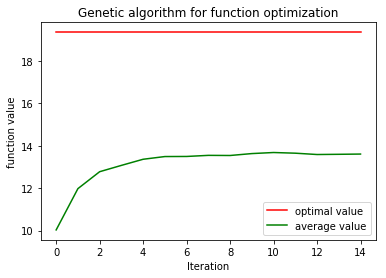

[get_adsets_active] adset_active_list: ['23843638403050266', '23843638403040266', '23843638403030266']
optimal_weight: [4.08425382 2.45376014 4.55821157 8.85742211 2.93737899 1.44779614
 9.87042618 9.4787472 ]
0:05:43.336295
0:05:43.336335
0:05:43.336358


In [3]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(23843318864630344)

In [4]:
#!jupyter nbconvert --to script genetic_algorithm_conversion_facebook.ipynb